# XGBoost submission v0

Steps:

1. Create Tabular Data with all active raw materials (12).
2. Add features (lags, etc.)
3. Train model
4. Create a submission frame
5. Forecast

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from collections import deque

# Set plot style for visual clarity
plt.style.use('seaborn-v0_8')

In [2]:
# Load the receival data
df = pd.read_csv('./data/kernel/receivals.csv')

# Load prediction mapping
prediction_mapping = pd.read_csv('./data/prediction_mapping.csv')

# Convert 'date_arrival' to timezone-naive datetime
df['date_arrival'] = pd.to_datetime(df['date_arrival'], utc=True).dt.tz_localize(None)

In [3]:
# Drop all rows where rm_id is missing

df = df.dropna(subset=['rm_id']).copy()

df = df.dropna(subset=['net_weight']).copy()
df = df.drop_duplicates().copy()

df

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15 11:34:00,Completed,11420.0,52062
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15 11:34:00,Completed,13760.0,52062
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15 11:38:00,Completed,11281.0,50468
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15 11:38:00,Completed,13083.0,50468
4,379.0,91900296.0,210435.0,20.0,1,NaN,2004-06-15 11:40:00,Completed,23910.0,52577
...,...,...,...,...,...,...,...,...,...,...
122585,3421.0,91900160.0,328740.0,30.0,1,1178422.0,2024-12-19 10:26:00,Completed,1220.0,69879
122586,2145.0,91900146.0,328740.0,20.0,2,1178431.0,2024-12-19 10:26:00,Completed,850.0,69879
122587,3865.0,91900143.0,328740.0,10.0,3,1178432.0,2024-12-19 10:26:00,Completed,14170.0,69879
122588,3901.0,91901440.0,330334.0,10.0,1,1178427.0,2024-12-19 10:54:00,Completed,15020.0,72195


## Create Tabular Data with all active raw materials.

In [4]:
# Aggregate to daily totals per rm_id
df_daily = (
    df.groupby(['rm_id', df['date_arrival'].dt.floor('D')])['net_weight']
    .sum()
    .reset_index()
    .rename(columns={'date_arrival': 'date'})
)

# Sort values for shifting
df_daily = df_daily.sort_values(['rm_id', 'date'])

df_daily

,rm_id,date,net_weight
0,342.0,2004-06-23,24940.0
1,343.0,2005-03-29,21760.0
2,345.0,2004-09-01,22780.0
3,346.0,2004-06-24,820.0
4,346.0,2004-06-30,21260.0
...,...,...,...
41926,4463.0,2024-10-17,2000.0
41927,4481.0,2024-10-29,24680.0
41928,4481.0,2024-11-27,22340.0
41929,4501.0,2024-12-02,23580.0


In [5]:
# 1. Get full date range
all_dates = pd.date_range(
    start=df_daily['date'].min(),
    end=df_daily['date'].max(),
    freq='D'
)
# print(all_dates)

# 2. Get all rm_ids
all_rm_ids = df_daily['rm_id'].unique()
print(len(all_rm_ids))

# 3. Create full Cartesian product of rm_id × date
full_index = pd.MultiIndex.from_product(
    [all_rm_ids, all_dates],
    names=['rm_id', 'date']
)

# 4. Reindex dataframe onto full grid
df_full = (
    df_daily.set_index(['rm_id', 'date'])
    .reindex(full_index, fill_value=0)  # fill missing with 0
    .reset_index()
)

df_full

203


,rm_id,date,net_weight
0,342.0,2004-06-15,0.0
1,342.0,2004-06-16,0.0
2,342.0,2004-06-17,0.0
3,342.0,2004-06-18,0.0
4,342.0,2004-06-19,0.0
...,...,...,...
1521074,4501.0,2024-12-15,0.0
1521075,4501.0,2024-12-16,0.0
1521076,4501.0,2024-12-17,0.0
1521077,4501.0,2024-12-18,0.0


In [6]:
material_status = {}

for rm, group in df_full.groupby('rm_id'):
    active_dates = group.loc[group['net_weight'] > 0, 'date']
    
    if active_dates.empty:
        # never active at all
        material_status[rm] = "never_active"
        continue
    
    first_active = active_dates.min()
    last_active  = active_dates.max()
    
    # Case 1: Dead (active, then never again after last_active)
    if last_active < df_full['date'].max():
        material_status[rm] = "dead"
    
    else:
        # Check if there are multiple disjoint active periods
        gaps = (active_dates.sort_values().diff().dt.days > 60).sum()
        if gaps > 0:
            material_status[rm] = "seasonal"
        else:
            # Active continuously once it starts
            if first_active > df_full['date'].min():
                material_status[rm] = "emerging"
            else:
                material_status[rm] = "continuous"

In [7]:
dead_rms      = [rm for rm, status in material_status.items() if status == "dead"]
seasonal_rms  = [rm for rm, status in material_status.items() if status == "seasonal"]
emerging_rms  = [rm for rm, status in material_status.items() if status == "emerging"]
continuous_rms= [rm for rm, status in material_status.items() if status == "continuous"]
never_active  = [rm for rm, status in material_status.items() if status == "never_active"]

print("Dead series:", len(dead_rms))
print("Seasonal series:", len(seasonal_rms))
print("Emerging series:", len(emerging_rms))
print("Continuous series:", len(continuous_rms))
print("Never active:", len(never_active))

Dead series: 191
Seasonal series: 5
Emerging series: 7
Continuous series: 0
Never active: 0


-> Exclude all of the 191 dead series.

Later set the predictions of those to 0.

In [8]:
df_full = df_full[df_full['rm_id'].isin(seasonal_rms + emerging_rms)]

## Add features (lags, etc.)

In [9]:
df_full['year'] = df_full['date'].dt.year
df_full['month'] = df_full['date'].dt.month
df_full['day'] = df_full['date'].dt.day
df_full['dayofweek'] = df_full['date'].dt.dayofweek
df_full['is_weekend'] = df_full['dayofweek'].isin([5,6]).astype(int)

# Add days since the last receival of the raw material as feature

# Sort values
df_full = df_full.sort_values(['rm_id', 'date'])

# Identify all receival dates
df_full['receival_date'] = df_full['date'].where(df_full['net_weight'] > 0)

# Function for last non-self receival
def get_last_nonself_receival(s):
    ffilled = s.ffill()
    mask_self = (ffilled.index == ffilled)
    shifted = ffilled.shift(1)
    return ffilled.where(~mask_self, shifted)

# Apply per rm_id
df_full['last_receival_date'] = (
    df_full.groupby('rm_id', group_keys=False)['receival_date']
    .transform(get_last_nonself_receival)
)

# Compute days since last receival
df_full['days_since_last'] = (df_full['date'] - df_full['last_receival_date']).dt.days
df_full['days_since_last'] = df_full['days_since_last'].fillna(999).astype(int)

# Create lag features
lags = [1, 2, 3, 4, 5, 6, 7, 30, 365]

for lag in lags:
    df_full[f'lag_{lag}'] = df_full.groupby('rm_id')['net_weight'].shift(lag)

# Drop everything that has NaN values (where Lags (features) are missing).
df_full = df_full.dropna(subset=[f"lag_{l}" for l in lags])

df_full

C:\Users\maxiw\AppData\Local\Temp\ipykernel_24044\947482179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['year'] = df_full['date'].dt.year
C:\Users\maxiw\AppData\Local\Temp\ipykernel_24044\947482179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['month'] = df_full['date'].dt.month
C:\Users\maxiw\AppData\Local\Temp\ipykernel_24044\947482179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,rm_id,date,net_weight,year,month,day,dayofweek,is_weekend,receival_date,last_receival_date,days_since_last,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_30,lag_365
554847,2129.0,2005-06-15,0.0,2005,6,15,2,0,NaT,NaT,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554848,2129.0,2005-06-16,0.0,2005,6,16,3,0,NaT,NaT,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554849,2129.0,2005-06-17,0.0,2005,6,17,4,0,NaT,NaT,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554850,2129.0,2005-06-18,0.0,2005,6,18,5,1,NaT,NaT,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554851,2129.0,2005-06-19,0.0,2005,6,19,6,1,NaT,NaT,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371214,3901.0,2024-12-15,0.0,2024,12,15,6,1,NaT,2024-12-12,3,0.0,0.0,24340.0,0.0,33080.0,0.0,0.0,23660.0,0.0
1371215,3901.0,2024-12-16,39180.0,2024,12,16,0,0,2024-12-16,2024-12-16,0,0.0,0.0,0.0,24340.0,0.0,33080.0,0.0,0.0,0.0
1371216,3901.0,2024-12-17,24180.0,2024,12,17,1,0,2024-12-17,2024-12-17,0,39180.0,0.0,0.0,0.0,24340.0,0.0,33080.0,0.0,17140.0
1371217,3901.0,2024-12-18,24340.0,2024,12,18,2,0,2024-12-18,2024-12-18,0,24180.0,39180.0,0.0,0.0,0.0,24340.0,0.0,0.0,0.0


In [10]:
# One hot encode rm_id to let the model have separate behaviour.

df_full_1 = pd.get_dummies(df_full, columns=['rm_id'])
df_full_1

,date,net_weight,year,month,day,dayofweek,is_weekend,receival_date,last_receival_date,days_since_last,...,rm_id_2134.0,rm_id_2142.0,rm_id_2143.0,rm_id_2144.0,rm_id_2145.0,rm_id_2741.0,rm_id_3126.0,rm_id_3421.0,rm_id_3865.0,rm_id_3901.0
554847,2005-06-15,0.0,2005,6,15,2,0,NaT,NaT,999,...,False,False,False,False,False,False,False,False,False,False
554848,2005-06-16,0.0,2005,6,16,3,0,NaT,NaT,999,...,False,False,False,False,False,False,False,False,False,False
554849,2005-06-17,0.0,2005,6,17,4,0,NaT,NaT,999,...,False,False,False,False,False,False,False,False,False,False
554850,2005-06-18,0.0,2005,6,18,5,1,NaT,NaT,999,...,False,False,False,False,False,False,False,False,False,False
554851,2005-06-19,0.0,2005,6,19,6,1,NaT,NaT,999,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371214,2024-12-15,0.0,2024,12,15,6,1,NaT,2024-12-12,3,...,False,False,False,False,False,False,False,False,False,True
1371215,2024-12-16,39180.0,2024,12,16,0,0,2024-12-16,2024-12-16,0,...,False,False,False,False,False,False,False,False,False,True
1371216,2024-12-17,24180.0,2024,12,17,1,0,2024-12-17,2024-12-17,0,...,False,False,False,False,False,False,False,False,False,True
1371217,2024-12-18,24340.0,2024,12,18,2,0,2024-12-18,2024-12-18,0,...,False,False,False,False,False,False,False,False,False,True


## Train Model

In [27]:
X = df_full_1.drop(columns=['date', 'net_weight', 'last_receival_date', 'receival_date'])

print("The features are: \n", list(X.columns))

The features are: 
 ['year', 'month', 'day', 'dayofweek', 'is_weekend', 'days_since_last', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_30', 'lag_365', 'rm_id_2129.0', 'rm_id_2130.0', 'rm_id_2134.0', 'rm_id_2142.0', 'rm_id_2143.0', 'rm_id_2144.0', 'rm_id_2145.0', 'rm_id_2741.0', 'rm_id_3126.0', 'rm_id_3421.0', 'rm_id_3865.0', 'rm_id_3901.0']


In [28]:
X = df_full_1.drop(columns=['date', 'net_weight', 'last_receival_date', 'receival_date'])

print("The features are: \n", X.columns)

y = df_full_1['net_weight']

print("Train period:", df_full_1['date'].min(), "→", df_full_1['date'].max())

# Train model
model = XGBRegressor(
    n_estimators=500,         # overfitting? before it was 1200
    learning_rate=0.05,       # before it was 0.01
    max_depth=8,              # allow complex per-material splits
    min_child_weight=6,       # prevent overfitting small spikes

    # --- Subsampling ---
    subsample=0.8,            # small randomness → better generalization
    colsample_bytree=0.8,     # use most features (lags + rm_id dummies)

    # --- Regularization ---
    reg_alpha=0.5,            # L1 regularization → sparsity
    reg_lambda=1.0,           # L2 regularization → stability

    # --- Advanced ---
    tree_method='hist',       # fast + memory-efficient
    random_state=42,
    n_jobs=-1,

    objective='reg:quantileerror', # use quantile loss
    quantile_alpha=0.2,
)

# --- Track training loss ---
evals_result = {}

model.fit(
    X, y,
    eval_set=[(X, y)],
    # eval_metric=["rmse"],      
    verbose=False,             # True or int for printed output
    # evals_result=evals_result
)

The features are: 
 Index(['year', 'month', 'day', 'dayofweek', 'is_weekend', 'days_since_last',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_30',
       'lag_365', 'rm_id_2129.0', 'rm_id_2130.0', 'rm_id_2134.0',
       'rm_id_2142.0', 'rm_id_2143.0', 'rm_id_2144.0', 'rm_id_2145.0',
       'rm_id_2741.0', 'rm_id_3126.0', 'rm_id_3421.0', 'rm_id_3865.0',
       'rm_id_3901.0'],
      dtype='object')
Train period: 2005-06-15 00:00:00 → 2024-12-19 00:00:00


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, objective='reg:quantileerror', ...)

dict_keys(['validation_0'])
odict_keys(['quantile'])


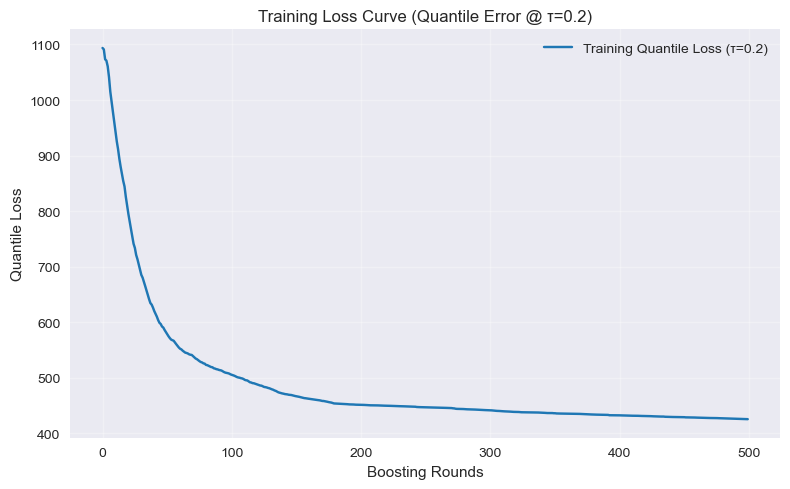

Final training Quantile Loss: 425.6505


In [29]:
# Get logged results
evals_result = model.evals_result()

# Inspect available metrics
print(evals_result.keys())                     # typically ['validation_0', 'validation_1']
print(evals_result['validation_0'].keys())     # check metric names, e.g. ['quantile']

# Extract quantile training loss
train_q = evals_result['validation_0']['quantile']

# Plot training quantile loss
plt.figure(figsize=(8,5))
plt.plot(train_q, label='Training Quantile Loss (τ=0.2)', color='tab:blue')
plt.xlabel('Boosting Rounds')
plt.ylabel('Quantile Loss')
plt.title('Training Loss Curve (Quantile Error @ τ=0.2)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training Quantile Loss (mean over all training samples): {train_q[-1]:.4f}")


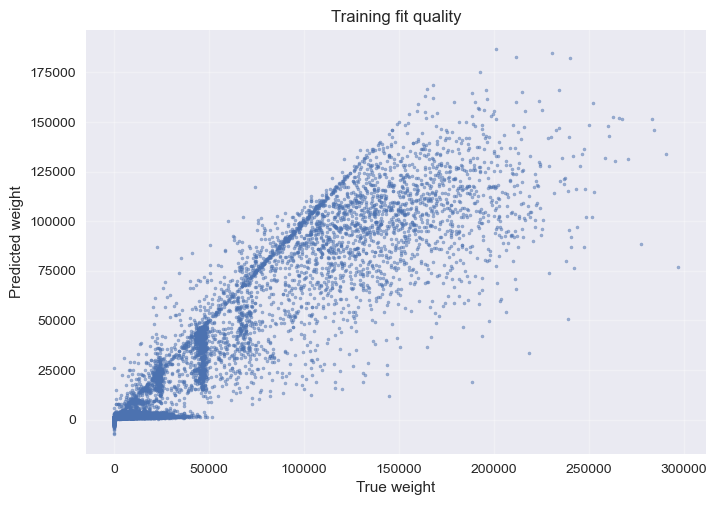

In [30]:
plt.scatter(y, model.predict(X), s=5, alpha=0.5)
plt.xlabel("True weight")
plt.ylabel("Predicted weight")
plt.title("Training fit quality")
plt.grid(True, alpha=0.3)
plt.show()

## Create a submission frame

In [31]:
future_dates = pd.date_range("2025-01-01", "2025-05-31", freq="D")

# Use only your 12 active rm_ids (seasonal + emerging)
active_rm_ids = seasonal_rms + emerging_rms

# Create full index of (rm_id, date) combinations ---
submission_frame = (
    pd.MultiIndex
    .from_product([active_rm_ids, future_dates], names=['rm_id', 'date'])
    .to_frame()
    .reset_index(drop=True)
)

# Add calendar / temporal features ---
submission_frame['year'] = submission_frame['date'].dt.year
submission_frame['month'] = submission_frame['date'].dt.month
submission_frame['day'] = submission_frame['date'].dt.day
submission_frame['dayofweek'] = submission_frame['date'].dt.dayofweek
submission_frame['is_weekend'] = submission_frame['dayofweek'].isin([5, 6]).astype(int)

# Add one-hot encoded rm_id columns (to match training data) ---
rm_dummies = pd.get_dummies(submission_frame['rm_id'], prefix='rm_id')
submission_frame = pd.concat([submission_frame, rm_dummies], axis=1)

# Ensure same column order as in training ---

feature_cols = ['date', 'rm_id'] + list(X.columns)
for col in [c for c in feature_cols if c not in submission_frame.columns]:
    submission_frame[col] = 0  # add any missing feature column (safety)

submission_frame = submission_frame[feature_cols]

print("Submission frame shape:", submission_frame.shape)
submission_frame.head()

Submission frame shape: (1812, 29)


,date,rm_id,year,month,day,dayofweek,is_weekend,days_since_last,lag_1,lag_2,...,rm_id_2134.0,rm_id_2142.0,rm_id_2143.0,rm_id_2144.0,rm_id_2145.0,rm_id_2741.0,rm_id_3126.0,rm_id_3421.0,rm_id_3865.0,rm_id_3901.0
0,2025-01-01,2129.0,2025,1,1,2,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,2025-01-02,2129.0,2025,1,2,3,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2025-01-03,2129.0,2025,1,3,4,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,2025-01-04,2129.0,2025,1,4,5,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,2025-01-05,2129.0,2025,1,5,6,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## Forecast

In [32]:
lags

[1, 2, 3, 4, 5, 6, 7, 30, 365]

In [34]:
max_lag = max(lags)

# Initialize a rolling history for each rm_id
history = {}
last_seen = {}

for rm in active_rm_ids:
    past_values = (
        df_full.loc[
            (df_full['rm_id'] == rm) & (df_full['date'] <= '2024-12-31'),
            'net_weight'
        ]
        .tail(max_lag)
        .tolist()
    )
    history[rm] = deque(past_values, maxlen=max_lag)

    # last nonzero receival date
    last_nonzero = (
        df_full.loc[
            (df_full['rm_id'] == rm) & (df_full['net_weight'] > 0),
            'date'
        ]
        .max()
    )
    last_seen[rm] = last_nonzero

In [18]:
last_seen

{2129.0: Timestamp('2024-12-19 00:00:00'),
 2142.0: Timestamp('2024-12-19 00:00:00'),
 2143.0: Timestamp('2024-12-19 00:00:00'),
 2145.0: Timestamp('2024-12-19 00:00:00'),
 2741.0: Timestamp('2024-12-19 00:00:00'),
 2130.0: Timestamp('2024-12-19 00:00:00'),
 2134.0: Timestamp('2024-12-19 00:00:00'),
 2144.0: Timestamp('2024-12-19 00:00:00'),
 3126.0: Timestamp('2024-12-19 00:00:00'),
 3421.0: Timestamp('2024-12-19 00:00:00'),
 3865.0: Timestamp('2024-12-19 00:00:00'),
 3901.0: Timestamp('2024-12-19 00:00:00')}

In [19]:
# Make predictions

In [35]:
preds = []

# Walk through each date sequentially
for date in tqdm(sorted(submission_frame['date'].unique()), desc="Recursive forecasting"):
    day_rows = submission_frame[submission_frame['date']==date].copy()

    # Build days_since_last
    for i, row in day_rows.iterrows():
        rm = row['rm_id']
        last_seen_date = last_seen[rm]

        day_rows.at[i, 'days_since_last'] = (date - last_seen_date).days

    # Build lag features from history buffer
    for i, row in day_rows.iterrows():
        rm = row['rm_id']
        hist_list = list(history[rm])
        for l in lags:
            # lag_l = value l days ago -> negative indexing
            if l <= len(hist_list):
                day_rows.at[i, f'lag_{l}'] = hist_list[-l]
            else:
                day_rows.at[i, f'lag_{l}'] = 0
    
    # Build X for this day
    X_day = day_rows[X.columns]

    # Predict for all rm_ids on this day
    y_day_pred = model.predict(X_day)

    # Save predictions
    preds.extend(y_day_pred)

    # Update last_seen
    for (i, row), yhat in zip(day_rows.iterrows(), y_day_pred):
        rm = row['rm_id']
        if yhat > 0:
            last_seen[rm] = date
        
    # Update history buffer with new prediction
    for (i, row), yhat in zip(day_rows.iterrows(), y_day_pred):
        rm = row['rm_id']
        history[rm].append(yhat)

# Attach predictions to forecasting submission frame
submission_frame['y_pred_recursive'] = [max(0, p) for p in preds]

Recursive forecasting: 100%|██████████| 151/151 [00:07<00:00, 19.74it/s]


In [36]:
submission_frame

,date,rm_id,year,month,day,dayofweek,is_weekend,days_since_last,lag_1,lag_2,...,rm_id_2142.0,rm_id_2143.0,rm_id_2144.0,rm_id_2145.0,rm_id_2741.0,rm_id_3126.0,rm_id_3421.0,rm_id_3865.0,rm_id_3901.0,y_pred_recursive
0,2025-01-01,2129.0,2025,1,1,2,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.000000
1,2025-01-02,2129.0,2025,1,2,3,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.000000
2,2025-01-03,2129.0,2025,1,3,4,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.000000
3,2025-01-04,2129.0,2025,1,4,5,1,0,0,0,...,False,False,False,False,False,False,False,False,False,0.000000
4,2025-01-05,2129.0,2025,1,5,6,1,0,0,0,...,False,False,False,False,False,False,False,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,2025-05-27,3901.0,2025,5,27,1,0,0,0,0,...,False,False,False,False,False,False,False,False,True,0.000000
1808,2025-05-28,3901.0,2025,5,28,2,0,0,0,0,...,False,False,False,False,False,False,False,False,True,755.924561
1809,2025-05-29,3901.0,2025,5,29,3,0,0,0,0,...,False,False,False,False,False,False,False,False,True,1.114089
1810,2025-05-30,3901.0,2025,5,30,4,0,0,0,0,...,False,False,False,False,False,False,False,False,True,0.000000


C:\Users\maxiw\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\maxiw\AppData\Local\Temp\ipykernel_24044\583195698.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


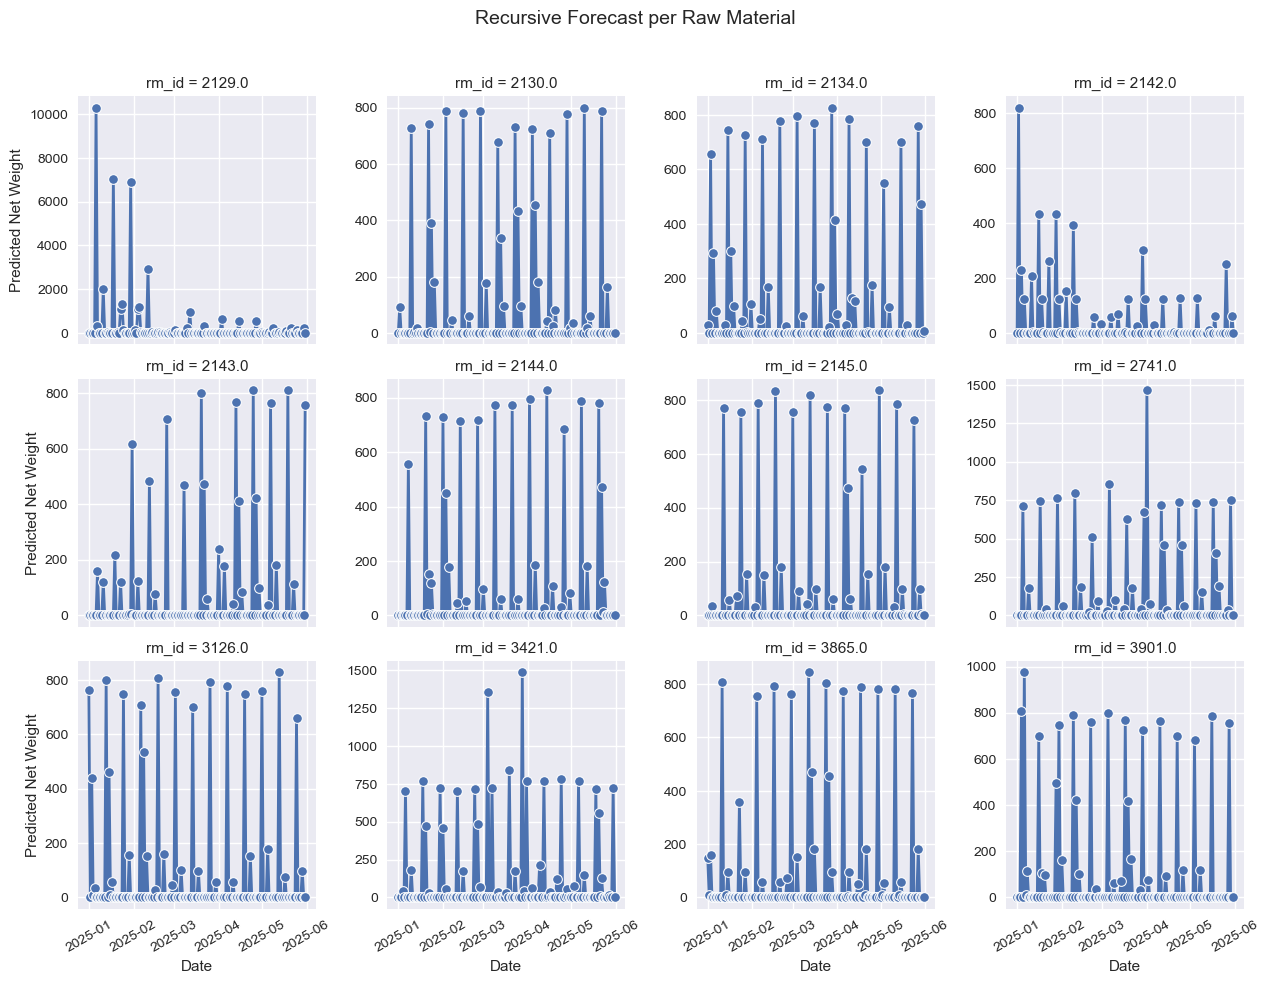

In [37]:
# Ensure correct date type and sorting
submission_frame['date'] = pd.to_datetime(submission_frame['date'])
submission_frame = submission_frame.sort_values(['rm_id', 'date'])

# Create facet grid — one plot per rm_id
g = sns.FacetGrid(
    submission_frame,
    col='rm_id',
    col_wrap=4,          # 4 plots per row → 3 rows for 12 materials
    height=3.2,          # height per subplot
    sharex=True,
    sharey=False,        # each material can have its own y-scale
)

# Add the time series lines
g.map_dataframe(
    sns.lineplot,
    x='date',
    y='y_pred_recursive',
    linewidth=2,
    marker='o'
)

# Titles and labels
g.set_titles("rm_id = {col_name}")
g.set_axis_labels("Date", "Predicted Net Weight")
g.fig.suptitle("Recursive Forecast per Raw Material", fontsize=14, y=1.02)

# Optional: improve date formatting
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)

plt.tight_layout()
plt.show()

## Create Kaggle submission

In [38]:
# Ensure correct date type
submission_frame['date'] = pd.to_datetime(submission_frame['date'])

# Filter only 2025 dates (Kaggle forecast period)
submission_2025 = submission_frame[submission_frame['date'] >= '2025-01-01'].copy()

# Sort before cumulative summation
submission_2025.sort_values(['rm_id', 'date'], inplace=True)

# Compute cumulative sums per rm_id
submission_2025['cum_sum'] = (
    submission_2025
    .groupby('rm_id')['y_pred_recursive']
    .cumsum()
)

# Keep only dates from Jan 2 onwards for submission
submission_2025 = submission_2025[submission_2025['date'] >= '2025-01-02'].copy()

# Rename columns for Kaggle format
final_submission = submission_2025.rename(
    columns={
        'date': 'forecast_end_date',
        'cum_sum': 'weight_kg'
    }
)

# Add forecast_start_date (constant for all rows)
final_submission['forecast_start_date'] = pd.Timestamp('2025-01-01')

# Reorder columns to Kaggle’s expected format
final_submission = final_submission[['forecast_start_date', 'forecast_end_date', 'rm_id', 'weight_kg']]

# 5️⃣ Handle missing rm_ids (dead_rms)
forecast_dates = sorted(final_submission['forecast_end_date'].unique())

# Create zero-filled rows for all dead rm_ids across all forecast dates
zero_fill = pd.DataFrame(
    [(pd.Timestamp('2025-01-01'), d, rm, 0.0) for rm in dead_rms for d in forecast_dates],
    columns=['forecast_start_date', 'forecast_end_date', 'rm_id', 'weight_kg']
)

# Combine predicted + zero-filled
final_submission = pd.concat([final_submission, zero_fill], ignore_index=True)

# 6️⃣ Sort and clean
final_submission.sort_values(['rm_id', 'forecast_end_date'], inplace=True)
final_submission.reset_index(drop=True, inplace=True)

# ✅ Preview
print(f"Final submission shape: {final_submission.shape}")
final_submission.head()

Final submission shape: (30450, 4)


,forecast_start_date,forecast_end_date,rm_id,weight_kg
0,2025-01-01,2025-01-02,342.0,0.0
1,2025-01-01,2025-01-03,342.0,0.0
2,2025-01-01,2025-01-04,342.0,0.0
3,2025-01-01,2025-01-05,342.0,0.0
4,2025-01-01,2025-01-06,342.0,0.0


In [39]:
prediction_mapping

,ID,rm_id,forecast_start_date,forecast_end_date
0,1,365,2025-01-01,2025-01-02
1,2,365,2025-01-01,2025-01-03
2,3,365,2025-01-01,2025-01-04
3,4,365,2025-01-01,2025-01-05
4,5,365,2025-01-01,2025-01-06
...,...,...,...,...
30445,30446,4501,2025-01-01,2025-05-27
30446,30447,4501,2025-01-01,2025-05-28
30447,30448,4501,2025-01-01,2025-05-29
30448,30449,4501,2025-01-01,2025-05-30


In [40]:
# Ensure datetime consistency
final_submission['forecast_start_date'] = pd.to_datetime(final_submission['forecast_start_date'])
final_submission['forecast_end_date'] = pd.to_datetime(final_submission['forecast_end_date'])
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

# Merge predictions with mapping
submission_merged = prediction_mapping.merge(
    final_submission,
    on=['rm_id', 'forecast_start_date', 'forecast_end_date'],
    how='left'
)

# Replace missing predictions (for dead_rms etc.) with 0
submission_merged['weight_kg'] = submission_merged['weight_kg'].fillna(0)

# Rename and select final columns
final_kaggle_submission = (
    submission_merged[['ID', 'weight_kg']]
    .rename(columns={'weight_kg': 'predicted_weight'})
    .sort_values('ID')
    .reset_index(drop=True)
)

# Preview
final_kaggle_submission.head()

,ID,predicted_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [41]:
final_kaggle_submission.to_csv("submission_XGBoost_v0_quantile_loss_refined_params.csv", index=False)